In [1]:
import torch, torchvision
import os
import random
import dataset
import metrics
import time

import constants as cst
import numpy as np
import torch.nn as nn
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch.nn.functional as F

import loss_fn_v2 as loss_fn
from unet import UNET

In [2]:
random.seed(cst.SEED)
torch.manual_seed(cst.SEED)
np.random.seed(cst.SEED)

def predict_img(model, image, device, transform, out_threshold=0.5):
    with torch.no_grad():
        x = image
        logits = model(x.to(device))
        logits = transform(logits)
        y_pred = nn.Softmax(dim=1)(logits)
        proba = y_pred.detach().cpu().squeeze(0).numpy()[1, :, :]
        return proba > out_threshold

In [3]:
TERMS = ["br2"]
SIZE = (384, 512)
FOLDS = [0]    # 0 to 4 only 1 fold at a time here for computational resources limit

DEVICE_NAME = "cpu"
if torch.cuda.is_available():
    DEVICE_NAME = 'cuda:0'
DEVICE = torch.device(DEVICE_NAME)

Starting term: br2
Starting fold: 0
Training set length: 52
Validation set length: 14
Pre-testing set length: 13
Tversky
Epoch: 50
Validation: 0.017142854630947113.
Best: 0.017142854630947113.
Epoch: 100
Validation: 0.005882624536752701.
Best: 0.005882624536752701.
Epoch: 150
Validation: 0.0029995962977409363.
Best: 0.0029995962977409363.
Epoch: 200
Validation: 0.001805730164051056.
Best: 0.001805730164051056.
Epoch: 250
Validation: 0.0012376271188259125.
Best: 0.0012376271188259125.
Epoch: 300
Validation: 0.0009395331144332886.
Best: 0.0009395331144332886.
Epoch: 350
Validation: 0.0007812716066837311.
Best: 0.0007620304822921753.
Epoch: 400
Validation: 0.0006718188524246216.
Best: 0.0006513148546218872.
Epoch: 450
Validation: 0.0005820654332637787.
Best: 0.0005820654332637787.
Epoch: 500
Validation: 0.0005386918783187866.
Best: 0.0005332827568054199.
Epoch: 550
Validation: 0.0005129985511302948.
Best: 0.0005020909011363983.
Epoch: 600
Validation: 0.000552937388420105.
Best: 0.00048251

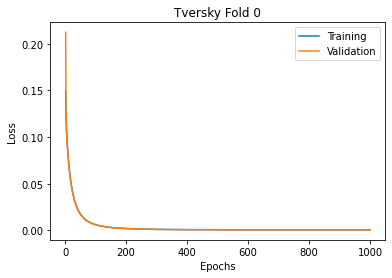

--------------------
Last epoch: 999
Term: br2
Fold: 0
Fold took: 326.0 minutes 57.0336377620697 seconds to train
Last val: 0.0004985183477401733
Best val: 0.0004356503486633301

Precision: 0.0
90% CI: [0. 0.]
Min, max: 0.0 0.0

Recall: 0.0
90% CI: [0. 0.]
Min, max: 0.0 0.0

F1/Dice score: 0.0
90% CI: [0. 0.]
Min, max: 0.0 0.0

IoU: 0.0
90% CI: [0. 0.]
Min, max: 0.0 0.0

--------------------

ALL FOLDS TRAINING ENDED
Mean best validation: 0.0004356503486633301
Mean precision: 0.0
Mean recall: 0.0
Mean F1: 0.0
Mean IOU: 0.0



In [4]:
for TERM in TERMS:
    print("Starting term: " + TERM)
    start_term = time.time()
    
    DATASET = "/notebooks/images"
    MASKS = "/notebooks/" + TERM
    
    transform = transforms.Compose([transforms.Resize(SIZE),
                                    transforms.Pad((0, 64, 0, 64))])
    untransform = transforms.Compose([transforms.CenterCrop(SIZE),
                                     transforms.Resize((1932, 2576))])
    
    fold_validation = []
    fold_precision = []
    fold_recall = []
    fold_f1 = []
    fold_IOU = []
    
    for fold in FOLDS:
        print("Starting fold: {}".format(fold))
        start_fold = time.time()
        """Datasets and loaders"""
        image_folder = DATASET
        mask_folder = MASKS
        training_set = dataset.ZebrafishDataset_KFold_v2(image_folder,
                                                      mask_folder,
                                                      actual_fold=fold,
                                                      dataset="train",
                                                      folds=cst.FOLDS)
        validation_set = dataset.ZebrafishDataset_KFold_v2(image_folder,
                                                        mask_folder,
                                                        actual_fold=fold,
                                                        dataset="validate",
                                                        folds=cst.FOLDS)
        testing_set = dataset.ZebrafishDataset_KFold_v2(image_folder,
                                                     mask_folder,
                                                     actual_fold=fold,
                                                     dataset="pre-test",
                                                     folds=cst.FOLDS)

        training_loader = torch.utils.data.DataLoader(training_set,
                                                      batch_size=cst.BATCH_SIZE,
                                                      shuffle=True,
                                                      num_workers=cst.WORKERS)

        validation_loader = torch.utils.data.DataLoader(validation_set,
                                                        batch_size=cst.BATCH_SIZE,
                                                        shuffle=True,
                                                        num_workers=cst.WORKERS)

        testing_loader = torch.utils.data.DataLoader(testing_set,
                                                     batch_size=1,
                                                     shuffle=True,
                                                     num_workers=cst.WORKERS)
        
        model = UNET(3, 2)
        model.to(DEVICE)
        best_model = UNET(3, 2)
        best_model = model
        
        criterion = nn.CrossEntropyLoss()
        criterion_string = "CE"

        if cst.LOSS == "Dice":
            print("Dice")
            criterion = loss_fn.DiceLoss()
            criterion_string = "DCE"
        if cst.LOSS == "IOU":
            print("IOU")
            criterion = loss_fn.IoULoss()
            criterion_string = "IOU"
        if cst.LOSS == "Tversky":
            print("Tversky")
            criterion = loss_fn.TverskyLoss(alpha=0.7, beta= 0.3)
            criterion_string = "Tversky"
        if cst.LOSS == "Focal":
            print("Focal")
            criterion = loss_fn.FocalLoss(alpha=0.8, gamma= 2, reduction="mean")
            criterion_string = "Focal"

        optimiser = torch.optim.Adam(model.parameters(), lr=cst.LEARNING_RATE, weight_decay=cst.WEIGHT_DECAY)
        optimiser_string = "ADAM" + "_" + "LR" + str(cst.LEARNING_RATE) + "_" + "WD" + str(cst.WEIGHT_DECAY)
        
        if cst.OPTIMIZER == "SGD":
            optimizer = torch.optim.SGD(model.parameters(),
                                        lr=cst.LEARNING_RATE,
                                        momentum=cst.MOMENTUM,
                                        weight_decay=cst.WEIGHT_DECAY)
            optimiser_string = "SGD" + "_" + "LR" + str(cst.LEARNING_RATE) + "_" + "M" + str(cst.MOMENTUM)
            optimiser_string += "_" + "WD" + str(cst.WEIGHT_DECAY)
        
        params_string = "Params" + "_" + "Epoch" + str(cst.EPOCHS) + "_" + "BS" + str(cst.BATCH_SIZE)
        params_string += "_" + "W" + str(cst.WORKERS)
        
        """Computing validation loss before training"""
        model.eval()
        with torch.no_grad():
            val_loss = []
            for images, masks, names in validation_loader:
                images = transform(images)
                outputs = model(images.to(DEVICE))
                outputs = untransform(outputs)

                masks = masks.type(torch.LongTensor)
                masks = torch.squeeze(masks, 1)

                vloss = criterion(outputs, masks.to(DEVICE))
                loss = vloss.detach().item()
                val_loss.append(loss)

            loss = np.mean(val_loss)
            # print("Validation loss before training: {}".format(loss))
            
        best_val = loss
        best_epoch = 0
        last_epoch = 0
        
        epochs_train_losses = []
        epochs_val_losses = []
        for epoch in range(cst.EPOCHS):
            # Training
            model.train()
            train_loss = []
            for images, masks, names in training_loader:
                images = transform(images)
                outputs = model(images.to(DEVICE))
                outputs = untransform(outputs)

                masks = masks.type(torch.LongTensor)
                masks = torch.squeeze(masks, 1)

                tloss = criterion(outputs, masks.to(DEVICE))
                loss = tloss.detach().item()
                train_loss.append(loss)

                optimiser.zero_grad()
                tloss.backward()
                optimiser.step()

            loss = np.mean(train_loss)
            epochs_train_losses.append(loss)
            #print("Trained: {}".format(loss), end=". ")

            """Validation"""
            model.eval()
            with torch.no_grad():
                val_loss = []
                for images, masks, names in validation_loader:
                    images = transform(images)
                    outputs = model(images.to(DEVICE))
                    outputs = untransform(outputs)

                    masks = masks.type(torch.LongTensor)
                    masks = torch.squeeze(masks, 1)

                    vloss = criterion(outputs, masks.to(DEVICE))
                    loss = vloss.detach().item()
                    val_loss.append(loss)

                loss = np.mean(val_loss)
                epochs_val_losses.append(loss)
                
                if loss < best_val:
                    best_val = loss
                    best_model = model
                    best_epoch = epoch+1
                
                if (epoch+1)%50 == 0:
                    print("Epoch: " + str(epoch+1))
                    #print("Training: {}".format(np.mean(train_loss)))
                    print("Validation: {}.".format(loss))
                    print("Best: {}.".format(best_val))
                    
            """Train and validate loops over"""
            curr = time.time()
            curr = curr - start_term
            secondes = curr % 60
            minutes = (curr-secondes)/60
            
            last_epoch = epoch
            
            if minutes >= 345:
                break
            if (epoch - best_epoch) >= 100:
                break
            
        """All epochs are over"""
        
        fold_validation.append(best_val)
        
        model_name = TERM + '_' + cst.LOSS + "_Fold_" + str(fold) + "_Epoch_" + str(best_epoch) + "_MaxEpochs_" 
        model_name += str(cst.EPOCHS) + '_' + cst.OPTIMIZER + "_LR_" + str(cst.LEARNING_RATE) + ".pth"
        
        model_filepath = os.path.join(cst.MODEL, model_name)
        torch.save(best_model.state_dict(), model_filepath)
        
        curr = time.time()
        curr = curr - start_fold
        secondes = curr % 60
        minutes = (curr-secondes)/60
        
        index = [i+1 for i in range(last_epoch+1)]
        plt.plot(index[1:], epochs_train_losses[1:], label="Training")
        plt.plot(index[1:], epochs_val_losses[1:], label="Validation")
        plt.title(str(cst.LOSS) + " Fold " + str(fold)) 
        plt.ylabel("Loss")
        plt.xlabel("Epochs")
        plt.legend()
        plt.show()
        """name = model_name[:-4]
        plot_name = name + ".png"
        plt.savefig(plot_name)"""
        
        tps = 0
        precisions = []
        recalls = []
        F1s = []
        IOUs = []

        eval_model = UNET(3, 2)
        eval_model = best_model

        eval_model.eval()
        for image, mask, name in testing_loader:
            image_name = name[0]
            prediction = predict_img(eval_model, transform(image), DEVICE, untransform, out_threshold=cst.THRESHOLD)
            pred = torch.from_numpy(prediction)

            precisions.append(metrics.precision(pred, mask))
            recalls.append(metrics.recall(pred, mask))
            F1s.append(metrics.F1Score(pred, mask))
            IOUs.append(metrics.IOUScore(pred, mask))
        
        mean_precision = np.mean(precisions)
        mean_recall = np.mean(recalls)
        mean_f1 = np.mean(F1s)
        mean_IOU = np.mean(IOUs)
        
        fold_precision.append(mean_precision)
        fold_recall.append(mean_recall)
        fold_f1.append(mean_f1)
        fold_IOU.append(mean_IOU)
        
        confidence = 0.9
        
        print("--------------------")
        print("Last epoch: {}".format(last_epoch))
        print("Term: " + TERM)
        print("Fold: {}".format(fold))
        print("Fold took: " + str(minutes) + " minutes " + str(secondes) + " seconds to train")
        print("Last val: {}".format(loss))
        print("Best val: {}".format(best_val))
        print()
        print("Precision: {}".format(mean_precision))
        print("90% CI: {}".format(np.percentile(precisions, [100*(1-confidence)/2,100*(1-(1-confidence)/2)])))
        print("Min, max:", np.min(precisions), np.max(precisions))
        print()

        print("Recall: {}".format(mean_recall))
        print("90% CI: {}".format(np.percentile(recalls, [100*(1-confidence)/2,100*(1-(1-confidence)/2)])))
        print("Min, max:", np.min(recalls), np.max(recalls))
        print()

        print("F1/Dice score: {}".format(mean_f1))
        print("90% CI: {}".format(np.percentile(F1s, [100*(1-confidence)/2,100*(1-(1-confidence)/2)])))
        print("Min, max:", np.min(F1s), np.max(F1s))
        print()

        print("IoU: {}".format(mean_IOU))
        print("90% CI: {}".format(np.percentile(IOUs, [100*(1-confidence)/2,100*(1-(1-confidence)/2)])))
        print("Min, max:", np.min(IOUs), np.max(IOUs))
        print()
        print("--------------------")
    """Fold loop end"""
    print()
    print("ALL FOLDS TRAINING ENDED")
    print("Mean best validation: {}".format(np.mean(fold_validation)))
    print("Mean precision: {}".format(np.mean(fold_precision)))
    print("Mean recall: {}".format(np.mean(fold_recall)))
    print("Mean F1: {}".format(np.mean(fold_f1)))
    print("Mean IOU: {}".format(np.mean(fold_IOU)))
"""term loop end"""
print()